In [1]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install -U sentencepiece
!pip install -U urllib3
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.9 MB/s eta 0:00:00
     ━

In [2]:
from datasets import load_dataset
from transformers import pipeline

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

In [3]:
device = 'gpu'
model_ckpt = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [4]:
# samsum = load_dataset('samsum')
raw_datasets = load_dataset('fairnightzz/anki-generated')
raw_datasets = raw_datasets["train"].train_test_split(test_size=0.1)
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['notes', 'cards'],
        num_rows: 388
    })
    test: Dataset({
        features: ['notes', 'cards'],
        num_rows: 44
    })
})

In [5]:
raw_datasets['train'][0]

{'notes': '- What is 0xF in decimal? Answer: 15\n- What is 0xA in decimal? Answer: 10\n- What is 0xA in binary? Answer: 1010\n- What is 0xB in binary? Answer: 1011\n- What is 0xC in binary? Answer: 1100\n- What is 0xD in binary? Answer: 1101\n\nPlease note that the responses to the flashcards have been separated for each set as requested. Let me know if you need any further assistance',
 'cards': '[Front: What is 0xF in decimal? Back: 15],\n[Front: What is 0xA in decimal? Back: 10],\n[Front: What is 0xA in binary? Back: 1010],\n[Front: What is 0xB in binary? Back: 1011],\n[Front: What is 0xC in binary? Back: 1100],\n[Front: What is 0xD in binary? Back: 1101]'}

In [6]:
notes_len = [len(x['notes'].split()) for x in raw_datasets['train']]
cards_len = [len(x['cards'].split()) for x in raw_datasets['train']]

array([[<Axes: title={'center': 'Notes Length'}>,
        <Axes: title={'center': 'Cards Length'}>]], dtype=object)

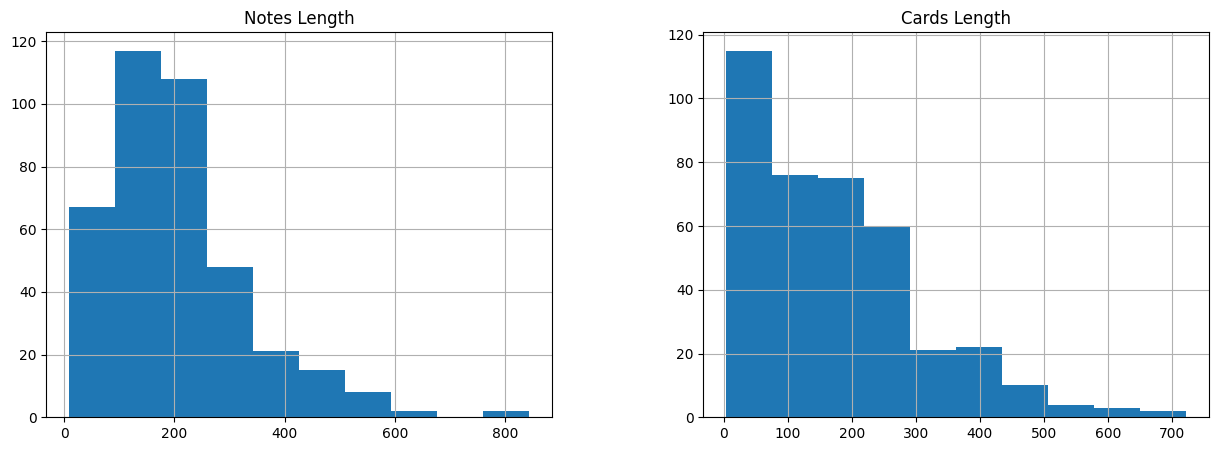

In [7]:
import pandas as pd

data = pd.DataFrame([notes_len, cards_len]).T
data.columns = ['Notes Length', 'Cards Length']

data.hist(figsize=(15,5))
# 500<512 which is min token size required, so suitable for all models

In [8]:
# lets build Data Collator

def get_feature(batch):
  encodings = tokenizer(batch['notes'], text_target=batch['cards'],
                        max_length=1024, truncation=True)

  encodings = {'input_ids': encodings['input_ids'],
               'attention_mask': encodings['attention_mask'],
               'labels': encodings['labels']}

  return encodings

In [9]:
datasets_pt = raw_datasets.map(get_feature, batched=True)

Map:   0%|          | 0/388 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

In [10]:
datasets_pt

DatasetDict({
    train: Dataset({
        features: ['notes', 'cards', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 388
    })
    test: Dataset({
        features: ['notes', 'cards', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 44
    })
})

In [11]:
columns = ['input_ids', 'labels', 'attention_mask']
datasets_pt.set_format(type='torch', columns=columns)
datasets_pt

DatasetDict({
    train: Dataset({
        features: ['notes', 'cards', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 388
    })
    test: Dataset({
        features: ['notes', 'cards', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 44
    })
})

In [12]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [21]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir = 'bart_notes2anki',
    num_train_epochs=1,
    # warmup_steps = 500,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay = 0.01,
    logging_steps = 10,
    evaluation_strategy = 'steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16,
    # eval_accumulation_steps=1
)

trainer = Trainer(model=model, args=training_args, tokenizer=tokenizer, data_collator=data_collator,
                  train_dataset = datasets_pt['train'], eval_dataset = datasets_pt['test'])

In [22]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=24, training_loss=1.581936001777649, metrics={'train_runtime': 107.1574, 'train_samples_per_second': 3.621, 'train_steps_per_second': 0.224, 'total_flos': 242131613024256.0, 'train_loss': 1.581936001777649, 'epoch': 0.99})

In [23]:
trainer.save_model('bart_notes2anki_model')

In [30]:
# custome Dialogue Prediction

pipe = pipeline('summarization', model='bart_notes2anki_model')
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "max_length": 1024}

custom_dialogue="""
Chapter 1: Introduction to Hamming Codes
- What is Hamming Code?
    - In telecommunication, Hamming codes are a family of linear error-correcting codes that generalize the Hamming(7,4)-code, and were invented by Richard Hamming in 1950. Hamming codes can detect up to two-bit errors or correct one-bit errors without detection of uncorrected errors.
- What are the properties of Hamming Codes?
    - Hamming codes can detect and correct errors in data transmission.
    - They can detect up to two-bit errors.
    - They can correct one-bit errors without detection of uncorrected errors.

Chapter 2: Basic Mathematical Operations
- What is the square root of 256?
    - The square root of 256 is 16.
- What is 2 raised to the power of 16?
    - 2^16 equals 65,536.."""
print(pipe(custom_dialogue, **gen_kwargs))

Your max_length is set to 1024, but your input_length is only 210. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=105)


[{'summary_text': '[Front: What is Hamming Code? Back: In telecommunication, Hamming codes are a family of linear error-correcting codes that generalize the Hamming(7,4)-code, and were invented by Richard Hamming in 1950. Hamming code can detect up to two bit errors or correct one-bit errors without detection of uncorrected errors].'}]


In [ ]:
!zip bart_samsum.zip -r bart_notes2anki_model/